# Importing Libraries

In [90]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image
import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

# Defining Constants
Some constants that we will be using so intead of writing them again and again we declare the first. 

In [116]:
CLASS_NAMES=['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
NUM_CLASSES=4
BASE_TRAIN_DIR="AlzheimerDataset\\train"
BASE_TEST_DIR="AlzheimerDataset\\test"
AUTOTUNE=tf.data.experimental.AUTOTUNE
NR_EPOCHS=50

# Preprocessing Our Dataset
Lets explore our data and see how many images we are working with of each type of dementia. 

In [4]:
NUM_IMAGES=[] #for keeping record of each type of record
for label in CLASS_NAMES:
    dir_name=f"{BASE_TRAIN_DIR}\{label[:-2]}ed"
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [5]:
print("Number of each type of image in our dataset:")
for label in range(4):
    print(f"{CLASS_NAMES[label]}:{NUM_IMAGES[label]}")

Number of each type of image in our dataset:
MildDementia:717
ModerateDementia:52
NonDementia:2560
VeryMildDementia:1792


By viewing the above output we can observe that our dataset is highly imbalanced.As we can see for on type of image we have 2500+ images for other we have only 52 images.<br>
This will greatly hamper the accuracy of our model. So to solve this model we must first balance our dataset a little bit so tha their is not so much difference between or data.<br>
For this we will be using Keras modules <b>ImageDataGenerator()</b> function which is used to pre process image data and also used for generating new data.

In [6]:

datagen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [15]:
for image in range(NUM_IMAGES[1]):
    img=load_img(f'AlzheimerDataset\\train\\ModerateDemented\\moderateDem{image}.jpg')
    x=img_to_array(img)
    x=x.reshape((1,)+x.shape)
    i=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='AlzheimerDataset\\train\\ModerateDemented',save_prefix='moderateDem',save_format='jpg'):
        i+=1
        if i>30:
            break

In [16]:
for image in range(NUM_IMAGES[0]):
    img=load_img(f'AlzheimerDataset\\train\\MildDemented\\mildDem{image}.jpg')
    x=img_to_array(img)
    x=x.reshape((1,)+x.shape)
    i=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='AlzheimerDataset\\train\\MildDemented',save_prefix='mildDem',save_format='jpg'):
        i+=1
        if i>2:
            break

In [20]:
NEW_NUM_IMAGES=[]
for label in CLASS_NAMES:
    dir_name=f"{BASE_TRAIN_DIR}\\{label[:-2]}ed"
    NEW_NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [23]:
print("New dataset with augmented images:")
for label in range(4):

    print(f"{CLASS_NAMES[label]}:{NEW_NUM_IMAGES[label]}")

New dataset with augmented images:
MildDementia:2611
ModerateDementia:1546
NonDementia:2560
VeryMildDementia:1792


Now our data looks fairly balanced as their is not as much marginal gap as before also we have more input images to train with.<br>
Using Keras preprocessing module we will take our image data as input from directory and prepocess our image data at the same time. We will be splitting our dataset into train dataset and validation dataset.

In [60]:

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TRAIN_DIR,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='training',
    seed=1000
)

Found 8509 files belonging to 4 classes.
Using 6808 files for training.


In [61]:

val_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TRAIN_DIR,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
)

Found 8509 files belonging to 4 classes.
Using 1701 files for validation.


In [62]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TEST_DIR,
    image_size=(224,224),
    batch_size=32,
    seed=1000
)

Found 1279 files belonging to 4 classes.


In [63]:
train_data.class_names=CLASS_NAMES
val_data.class_names=CLASS_NAMES

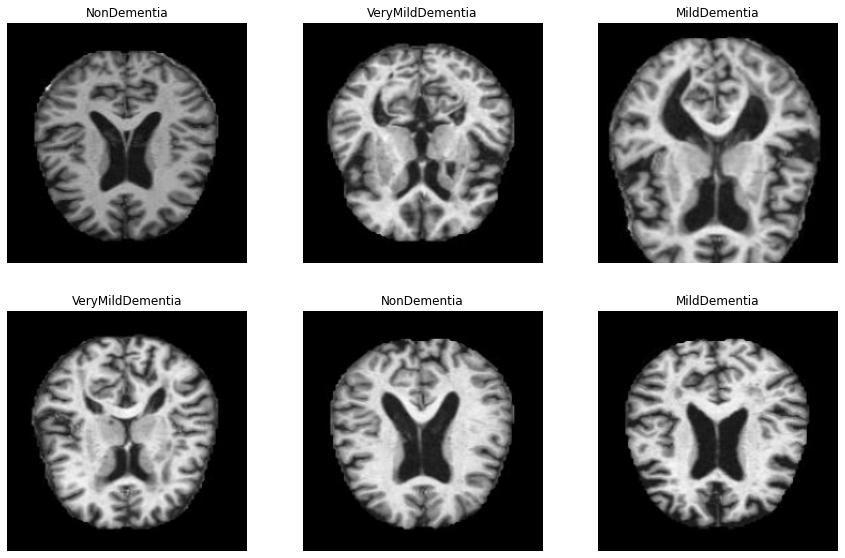

In [89]:
plt.figure(figsize=(15,15))
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
        plt.axis("off")
plt.savefig("sample.png")

# Defining our neural network 
After preporcessing our data we now come to making oura own neural network model. As weare working with image data it is a no brainer that we will be using a CNN model. We will be using our old friend Keras again to define our own neural network.

In [124]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(224,224, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [125]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_23 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 separable_conv2d_28 (Separa  (None, 112, 112, 32)     688       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_29 (Separa  (None, 112, 112, 32)     1344      
 bleConv2D)                                                      
                                                     

In [126]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
                )

In [127]:
model_sum=model.fit(train_data,
                    validation_data=val_data,
                    epochs=NR_EPOCHS)

Epoch 1/50
213/213 [==============================] - 401s 2s/step - loss: 1.0278 - accuracy: 0.5472 - val_loss: 2.7853 - val_accuracy: 0.3069
Epoch 2/50
213/213 [==============================] - 382s 2s/step - loss: 0.7346 - accuracy: 0.6548 - val_loss: 1.1088 - val_accuracy: 0.4368
Epoch 3/50
213/213 [==============================] - 401s 2s/step - loss: 0.5213 - accuracy: 0.7506 - val_loss: 0.5131 - val_accuracy: 0.7631
Epoch 4/50
213/213 [==============================] - 387s 2s/step - loss: 0.4269 - accuracy: 0.8098 - val_loss: 0.8520 - val_accuracy: 0.6414
Epoch 5/50
213/213 [==============================] - 393s 2s/step - loss: 0.2889 - accuracy: 0.8779 - val_loss: 0.3710 - val_accuracy: 0.8272
Epoch 6/50
213/213 [==============================] - 402s 2s/step - loss: 0.2243 - accuracy: 0.9116 - val_loss: 0.4857 - val_accuracy: 0.7960
Epoch 7/50
213/213 [==============================] - 398s 2s/step - loss: 0.1680 - accuracy: 0.9376 - val_loss: 0.5442 - val_accuracy: 0.7984

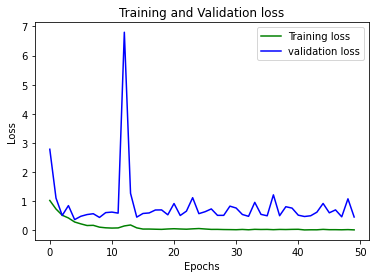

In [128]:
loss_train = model_sum.history['loss']
loss_val = model_sum.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_vs_val_loss.png")
plt.show()

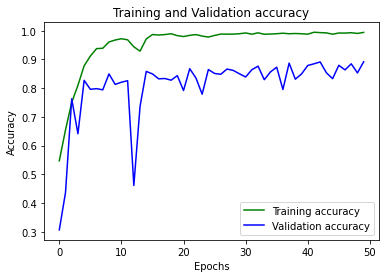

In [129]:
accuracy_train = model_sum.history['accuracy']
accuracy_val = model_sum.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("train_vs_val_acc.png")
plt.show()

In [132]:
model.evaluate(test_data)

40/40 [==============================] - 13s 318ms/step - loss: 1.9599 - accuracy: 0.5856


[1.959892988204956, 0.5856137871742249]

As we can se above:<br>
<b>Accuracy: 59%</b><br>
<b>Loss: 1.9%</b>

# Saving our and checking on  an Input image

In [134]:
model.save("model\\alzheimer_model.h5")

In [138]:
file_path='AlzheimerDataset\\test\\ModerateDemented\\27 (2).jpg'
image=tf.keras.preprocessing.image.load_img(file_path)
image=tf.image.resize(image,(224,224))
input_array=tf.keras.preprocessing.image.img_to_array(image)
input_array=np.array([input_array])
pred=model.predict(input_array)
res=np.argmax(pred)
re1=CLASS_NAMES[res]

1/1 [==============================] - 0s 43ms/step
